In [1]:
import torch
import torch.optim as optim
import os
import sys
import random
import matplotlib.pyplot as plt
# hack to perform relative imports
sys.path.append('../')
from ChrisCode import train_agent, SQN
import time

from Code import SNN


In [2]:
#torch.backends.cudnn.deterministic = True
import numpy as np
np.random.seed(1)

In [3]:
torch.get_num_threads()

4

Next, we define the environment and all the hyperparameters for a non-spiking Q-network. We then set up the result directory. 

In [4]:
#CartPole
env = 'CartPole-v0'

#hyperparameters
BATCH_SIZE = 128
DISCOUNT_FACTOR = 0.999
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.999
TARGET_UPDATE_FREQUENCY = 10
LEARNING_RATE = 0.001
REPLAY_MEMORY_SIZE = 4*10**4
# minimum size of the replay memory before the training starts
INITIAL_REPLAY_SIZE = 0
# the gym standard for CartPole ("solving" it) is to achieve a 100-episode average of <=195 for 100 consecutive episodes
GYM_TARGET_AVG = 195
GYM_TARGET_DURATION = 100
# maximum number of steps before the environment is reset
MAX_STEPS = 200
# number of episodes to train the agent
NUM_EPISODES = 1000 #TODO: change
# whether to use Double Q Learning and Gradient Clipping
DOUBLE_Q = True
GRADIENT_CLIPPING = True
# whether to render the environment
RENDER = False

# device: automatically runs on GPU, if a GPU is detected, else uses CPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")



### Training of a spiking DQN or DSQN
Next, we train a DSQN using the same hyperparameters as far as possible. That is, all hyperparameters are the same, but we need to define some additional hyperparameters. We adapted the surrogate gradient algorithm we use for the direct training from the SpyTorch jupyter notebooks (available from https://github.com/fzenke/spytorch as of 06.12.2019).

In [5]:
# First we set up a new sub directory

# We use a non-leaky integrate-and-fire neuron
ALPHA = 0
BETA = 1
# Simulation time is chosen relatively short, such that the network does not need too much time to run, but not too short,
# such that it can still learn something
SIMULATION_TIME = 20
# We also have to define the input/output and reset methods, to our knowledge, SpyTorch supports only potential outputs 
# and reset-by-subtraction. As input method we use constant input currents. It would be interesting to see if SpyTorch
# can also use reset-to-zero, as this would make it more similar to the iaf_delta models in NEST and SpyNNaker
ENCODING = 'constant'
DECODING = 'potential'
RESET = 'subtraction'
# SpyTorch uses a fixed threshold of one, we didn't test other thresholds, but should be possible
THRESHOLD = 1




In [6]:
#architecture = [4,16,16,2]
architecture = [4,64,2]


neuron_params = {
    'threshold': 1,
    'alpha': ALPHA,
    'beta': 1,
    'reset_zero': False,
    'decay': 1
}

neuron = SNN.NonLeaky #SNN.AdaptiveNonLeaky
outputneuron = SNN.NLPotential
spikefn = SNN.BellecSpike.apply #SNN.AdaptiveBellec.apply

#my_net = SNN.FeedForwardSNN(architecture, SNN.LIFNeuron, neuron_params, SNN.SuperSpike.apply, SNN.PotentialNeuron).to(device)
#my_target_net = SNN.FeedForwardSNN(architecture, SNN.LIFNeuron, neuron_params, SNN.SuperSpike.apply, SNN.PotentialNeuron).to(device)


my_net = SNN.RSNN(architecture, neuron, neuron_params, spikefn, outputneuron).to(device)
my_target_net = SNN.RSNN(architecture, neuron, neuron_params, spikefn, outputneuron).to(device)



KeyboardInterrupt: 

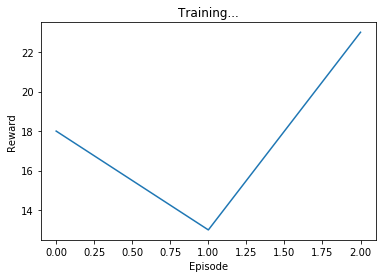

In [7]:
policy_net = my_net
target_net = my_target_net

torch.manual_seed(467)
random.seed(208)
gym_seed = 216

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
start = time.time()
train_agent.train_agent(env,policy_net,target_net,BATCH_SIZE,DISCOUNT_FACTOR,EPSILON_START,
            EPSILON_END,EPSILON_DECAY,TARGET_UPDATE_FREQUENCY,optimizer,LEARNING_RATE,
            REPLAY_MEMORY_SIZE,device,GYM_TARGET_AVG,GYM_TARGET_DURATION,num_episodes=NUM_EPISODES,
            max_steps=MAX_STEPS,render=RENDER,double_q_learning=DOUBLE_Q,gradient_clipping=GRADIENT_CLIPPING,
            initial_replay_size=INITIAL_REPLAY_SIZE,gym_seed=gym_seed)

In [ ]:
time.time()-start



In [ ]:
testinp2 = torch.rand((128,4), dtype=torch.float, device=device)

start = time.time()
for i in range(1000):
    #testinp2 = torch.rand((128,4), dtype=torch.float, device=device)
    out = policy_net.forward(testinp2)
    out.sum().backward()
print(time.time()-start)


